# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

## 1. Explore the Environment

First part of the notebook introduces Unity Reacher enviroment and lets you explore its state and actions spaces

### 1.1. Install the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [15]:
#!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

### 1.2. Create Unity environment wrapper
We need to create Environment wrapper which allows our agent to communicate with Unity environment in an easy way. Just simplifying interface.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

class EnvironmentWrapper():
    def __init__(self, file_name):
        self.env = UnityEnvironment(file_name=file_name, worker_id=1)
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.action_size = self.brain.vector_action_space_size
        
        self.env_info = self.env.reset(train_mode=False)[self.brain_name]
        states = self.env_info.vector_observations
        self.state_size = states.shape[1]
        
    def reset(self, train_mode=False):
        self.env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        state = self.env_info.vector_observations
        
        return state
        
    def close(self):
        self.env.close()
        
    def step(self, actions):
        self.env_info = self.env.step(actions)[self.brain_name]       
        next_state = self.env_info.vector_observations   
        reward = self.env_info.rewards
        #reward = [x * 10.0 for x in reward]
        done = self.env_info.local_done                
        return next_state, reward, done

Load single agent environemnt

In [2]:
env = EnvironmentWrapper(file_name="reacher/reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 1.3 Explore the Environemnt

Show environment state and action sizes

In [3]:
print (env.action_size)
print (env.state_size)

4
33


In [4]:
# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='reacher-m/reacher.exe', )

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.env.brain_names[0]
brain = env.env.brains[brain_name]

### 1.4. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.30408478e+00 -1.00000000e+00
 -4.92529202e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.33014059e-01]


### 1.4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [10]:
env_info = env.env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.36999999172985554


When finished, you can close the environment.

### 2. Train DDPG based Agent

Now it's time to train agent to solve the environment! When training the environment. We implemented DDPG algorithm described in the paper: https://arxiv.org/abs/1509.02971 

### 2.1. Import PyTorch
First we need to import PyTorch library so we can start building two networks:  Policy Network (Actor) to generate actions an Q-Network (Critic) to calculate Q value of generated action.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


### 2.2. Setup Network Archtiectures
For the Policy network (Actor) we ended up with simple three layers fully connected network with Relu as activation functions and Batch Normalization  For Q-Network (Critic) we come up with four layers fully connected network with Relu as activation functions.  Dropout regularization is also used to improve Network generalization.

In [29]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.state_size =  state_size
        
        self.fc1 = nn.Linear(self.state_size, 128)
        self.batch_norm1 =  torch.nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 =  torch.nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, self.action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        # Layer 1
        x = self.fc1(state)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        # Layer 2
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        # Layer 3
        x = F.tanh(self.fc3(x))     
        
        return x
    
class Critic(nn.Module):
    """Critic (Q-Network) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.state_size =  state_size
        
        self.fc1s = nn.Linear(self.state_size, 128)
        self.fc2 = nn.Linear(128 + self.action_size, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
                
    def forward(self, state, action):
        """Build a network that maps state -> action values."""
        # State feature layer
        xs = F.relu(self.fc1s(state))
        
        # State freatures + action values
        x =  torch.cat((xs, action), dim=1)
        
        # Layer 2
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        
        # Layer 3
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=0.2, training=self.training)
        
        # Layer 4
        x = self.fc4(x)     
         
        return x   

### 2.3. Create Expirience Replay Buffer
We need to define class with will be used to store experience tuples. DDPG algorithm also uses previous expirience similar to the DQN for training. 

In [30]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 2.4. Create Ornstein-Uhlenbeck process class

As was mentioned in the original paper a major challenge of learning in continuous action spaces is exploration. So to make agent to explore we are adding some noise to the actions using an Ornstein-Uhlenbeck process.  So we need to define noise class to be used.

In [31]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### 2.5. Create agent

Create DDPG agent

In [32]:
from collections import namedtuple, deque
import random
import copy

# hyper params sample
hyperparams = { "BUFFER_SIZE" : int(1e5),  # replay buffer size
                "BATCH_SIZE" : 64,         # minibatch size
                "GAMMA" : 0.99,            # discount factor
                "TAU" : 1e-3,              # for soft update of target parameters
                "LR" : 1e-4,               # learning rate 
                "LEARN_EVERY" : 4,         # how often to update the networks
                "LEARN_ITERATIONS" : 10,   # how many iterations needed for each network update
              }

class DDPGAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, device, hyperparams, actor, critic, state_size, action_size, seed):
        """Initialize an DDPG Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.hyperparams = hyperparams
        
        self.device = device
           
        self.BUFFER_SIZE = hyperparams["BUFFER_SIZE"]
        self.BATCH_SIZE = hyperparams["BATCH_SIZE"]
        self.GAMMA = hyperparams["GAMMA"]
        self.TAU = hyperparams["TAU"]
        self.LR = hyperparams["LR"]
        
        self.LEARN_EVERY = hyperparams["LEARN_EVERY"]
        self.LEARN_ITERATIONS = hyperparams["LEARN_ITERATIONS"]
        
        self.state_size = state_size
        
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Actor
        self.actor = actor(state_size, action_size, seed).to(self.device)
        self.actor_target = actor(state_size, action_size, seed).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.LR)
        self.actor.eval()
       
         # Critic
        self.critic = critic(state_size, action_size, seed).to(self.device)
        self.critic_target = critic(state_size, action_size, seed).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.LR)
        self.critic.train()
        
        # Deep Q-Learning Algorithm: Initialize replay memory D with N = BUFFER_SIZE
        self.memory = ReplayBuffer(action_size, self.BUFFER_SIZE, self.BATCH_SIZE, seed)
       
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
         # Noise process
        self.noise = OUNoise(action_size, seed)
            
    def step(self, state, action, reward, next_state, done):
        # Save experience tuple (S, A, R, S~) in replay memory D
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.LEARN_EVERY
        if self.t_step == 0:
            # If enough samples are available in the memory, run learning cycle
            if len(self.memory) > self.BATCH_SIZE:
                # run learning cycle LEARN_ITERATIONS times 
                for _ in range(self.LEARN_ITERATIONS):
                    # Obtain random minibatch of tuples (S, A, R, S~) from replay memory D
                    experiences = self.memory.sample()
                    self.learn(experiences, self.GAMMA)
                    
                    # update target networks using soft update
                    self.soft_update(self.actor, self.actor_target, self.TAU)   
                    self.soft_update(self.critic, self.critic_target, self.TAU)   
    
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        states = torch.from_numpy(states).float().to(self.device)
        self.actor.eval()
        
        with torch.no_grad():
            action_values = self.actor(states).cpu().data.numpy()
        self.actor.train()
        
        # add noise to the actions to favor exploartion
        if add_noise:
            action_values += self.noise.sample() / 10.0
        
        # make sure that resulting value after adding noise is still in [-1, 1] interval
        return np.clip(action_values, -1.0, 1.0)

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        # Use random minibatch of tuples(S[j], A[j], R[j], S[j+1]) from replay memory D
        states, actions, rewards, next_states, dones = experiences
        
        with torch.no_grad():            
            # get continious actions vector according to the target policy network (Actor)
            # for the next states
            actions_next = self.actor_target(next_states)
            
            # evaluate q values for the actions proposed by policy network for the next states
            # Q(states_next, actions_next) by target Q network (Critic)
            Q_states_next_actions_next = self.critic_target(next_states,  actions_next)
                       
            # calculate target value
            # y[j]= r[j] if episode terminates (done = 1)
            y = rewards + gamma * Q_states_next_actions_next * (1.0 - dones)
        
        # get expected Q value 
        Q_expected = self.critic(states, actions)
        
        # critic loss is normal MSE loss, we need to minimize
        # difference between actual Q values and target Q values for specific state, action pairs
        critic_loss = F.mse_loss(Q_expected, y)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()
        
        # predict new actions according to current policy network
        predicted_actions = self.actor(states)
        
        # we need to maximize Q values calculated by critic based on predicted actions,
        # so we need to perform gradient ascent (minus sign)
        actor_loss = -self.critic(states, predicted_actions).mean()
        
        # backpropagation
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.noise.reset()
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 2.6. Setup training cycle

In [33]:
def train(env, agent, n_episodes=100, max_t=1000, model_file_actor = 'actor.pth', model_file_critic = 'critic.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    all_scores = []                     # list containing scores from each episode
    scores_window = deque(maxlen=100)   # last 100 scores
    scores_window10 = deque(maxlen=10)  # last 10 scores
    max_score = 0
    
    for i_episode in range(1, n_episodes+1):
        
        # Not sure why - sometimes unity environment is not reset after first call.
        # so call reset two times - works like a charm
        states = env.reset(train_mode=True)
        states = env.reset(train_mode=True)
        
        # reset scores for the episode
        scores = np.zeros(states.shape[0], dtype=float)
        
        # for time step t <- 1 to T:
        for t in range(max_t):
           
            # Choose action from state S using policy network:
            actions = agent.act(states)
        
            # Take an action and observe result
            next_states, rewards, dones = env.step(actions)
         
            # Sample and Learn section
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break 
      
        mean_score = np.mean(scores)
        scores_window10.append(mean_score)
        scores_window.append(mean_score)       # save most recent score
        all_scores.append(mean_score)              # save most recent score
        
        print('Episode {}\t Episode score: {:.3f} \t Mean-10 score: {:.3f} \t Mean-100 score: {:.3f}'
              .format(i_episode, mean_score, np.mean(scores_window10), np.mean(scores_window)))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score over 100 episodes: {:.3f}'.format(i_episode, np.mean(scores_window)))
        
            if np.mean(scores_window) > max_score:
                print('Saving model... Episode: {} \tAverage Score: {:.6f}\n'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.actor.state_dict(), model_file_actor)
                torch.save(agent.critic.state_dict(), model_file_critic)
                max_score = np.mean(scores_window)
        
        if np.mean(scores_window) > 30.5:
                print('Solved! Saving model... Episode: {} \tAverage Score: {:.6f}\n'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.actor.state_dict(), model_file_actor)
                torch.save(agent.critic.state_dict(), model_file_critic)
                max_score = np.mean(scores_window)
                break
                
    return all_scores

### 2.7. Set device and utility functions

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

def plot_comparison(models,  labels, periods):
    
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    
    for m, l in zip(models, labels):
        moving_m =  moving_average(m, periods)
        plt.plot(moving_m, label=l)
    
    plt.legend(loc='lower right')

    plt.title("DQN Models comparison", fontsize=12, fontweight='bold')
    plt.xlabel("Eisode #")
    plt.ylabel("Score")
    
    plt.show()

### 2.8. Train the agent

In [35]:
hyperparams = { "BUFFER_SIZE" : int(1e6),  # replay buffer size
                "BATCH_SIZE" : 1024,         # minibatch size
                "GAMMA" : 0.99,             # discount factor
                "TAU" : 1e-3,               # for soft update of target parameters
                "LR" : 1e-4,                # learning rate 
                "LEARN_EVERY" : 10,         # how often to update the network
                "LEARN_ITERATIONS" : 10,    # how many iterations needed for each network update
              }

agent = DDPGAgent(device, hyperparams, Actor, Critic, state_size=env.state_size, action_size=env.action_size, seed=222)

scores = train(env, agent, n_episodes=500, max_t=1000, model_file_actor = 'DDPG_actor.pth', model_file_critic = 'DDPG_critic.pth')

np.save("DDPGScores.npy", scores)

Episode 1	 Episode score: 0.970 	 Mean-10 score: 0.970 	 Mean-100 score: 0.970


C:\Users\alexeys\AppData\Local\Continuum\anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:143: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 2	 Episode score: 0.730 	 Mean-10 score: 0.850 	 Mean-100 score: 0.850
Episode 3	 Episode score: 0.800 	 Mean-10 score: 0.833 	 Mean-100 score: 0.833
Episode 4	 Episode score: 0.960 	 Mean-10 score: 0.865 	 Mean-100 score: 0.865
Episode 5	 Episode score: 1.090 	 Mean-10 score: 0.910 	 Mean-100 score: 0.910
Episode 6	 Episode score: 1.170 	 Mean-10 score: 0.953 	 Mean-100 score: 0.953
Episode 7	 Episode score: 1.110 	 Mean-10 score: 0.976 	 Mean-100 score: 0.976
Episode 8	 Episode score: 1.640 	 Mean-10 score: 1.059 	 Mean-100 score: 1.059
Episode 9	 Episode score: 2.170 	 Mean-10 score: 1.182 	 Mean-100 score: 1.182
Episode 10	 Episode score: 2.320 	 Mean-10 score: 1.296 	 Mean-100 score: 1.296
Episode 11	 Episode score: 0.620 	 Mean-10 score: 1.261 	 Mean-100 score: 1.235
Episode 12	 Episode score: 1.500 	 Mean-10 score: 1.338 	 Mean-100 score: 1.257
Episode 13	 Episode score: 1.850 	 Mean-10 score: 1.443 	 Mean-100 score: 1.302
Episode 14	 Episode score: 1.530 	 Mean-10 score

KeyboardInterrupt: 

#### Plot scores 

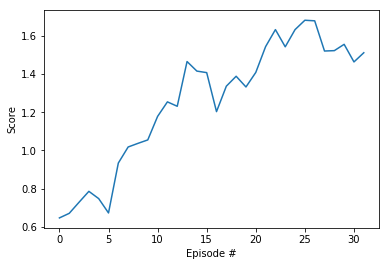

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

aver = moving_average(scores, 10)

plot_scores(aver)

### 2.9. Load agent and watch performance

In [18]:
hyperparams = { "BUFFER_SIZE" : int(1e6),  # replay buffer size
                "BATCH_SIZE" : 1024,         # minibatch size
                "GAMMA" : 0.99,             # discount factor
                "TAU" : 1e-3,               # for soft update of target parameters
                "LR" : 1e-4,                # learning rate 
                "LEARN_EVERY" : 10,         # how often to update the network
                "LEARN_ITERATIONS" : 10,    # how many iterations needed for each network update
              }

agent = DDPGAgent(device, hyperparams, Actor, Critic, state_size=env.state_size, action_size=env.action_size, seed=0)

actor_state_dict = torch.load('DDPG_actor.pth')
critic_state_dict = torch.load('DDPG_critic.pth')

agent.actor.load_state_dict(actor_state_dict)
agent.actor_target.load_state_dict(actor_state_dict)

agent.critic.load_state_dict(critic_state_dict)
agent.critic_target.load_state_dict(critic_state_dict)

states = env.reset(False)
score = 0                

while True:
    actions = agent.act(states, False)                
    next_states, rewards, dones = env.step(actions)            
    states = next_states  
    score += np.mean(rewards) 
    if np.any(dones):                                     
        break
    
print("Score: {}".format(score))

C:\Users\Alexey\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Score: 0.6399999856948853


In [ ]:
env.close()